In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import json
from cost_calulation import *

In [2]:
# Load all the data for a specific scenario
application = "hotel_reservation"
scenarios = ["browse", "reserve"]

# setups = [(name, color, tick_type, label)]
setups = [
    ("gcr", "g", "--", "GCR", "final_test_lower_payload"),
    ("gke_standard", "r", "--", "GKE Standard", "final_test_lower_payload"),
    ("gke_autopilot", "m", "--", "GKE Autopilot", "final_test_lower_payload"),
]
loads = [2, 4, 5, 6]



data = {}
for scenario in scenarios:
    data[scenario] = {}
    for load in loads:
        data[scenario][load] = {}
        for infra, _, _, _, run_id in setups:
            if infra not in data[scenario][load]:
                data[scenario][load][infra] = {}
            path = f"../results/{application}/{scenario}/{infra}/{run_id}/{load}"
            data_tmp = {}

            with open(f"{path}/gcp_metrics.json", "r") as f:
                data_tmp["gcp_metrics"] = json.load(f)
            with open(f"{path}/summary.json", "r") as f:
                data_tmp["k6_metrics"] = json.load(f)
            with open(f"{path}/statistics.json", "r") as f:
                data_tmp["statistics"] = json.load(f)
            
            data_tmp["percentiles"] = pd.read_csv(f"{path}/percentiles.csv")
            data_tmp["nr_requests"] = pd.read_csv(f"{path}/nr_requests.csv")
            data[scenario][load][infra][run_id] = data_tmp


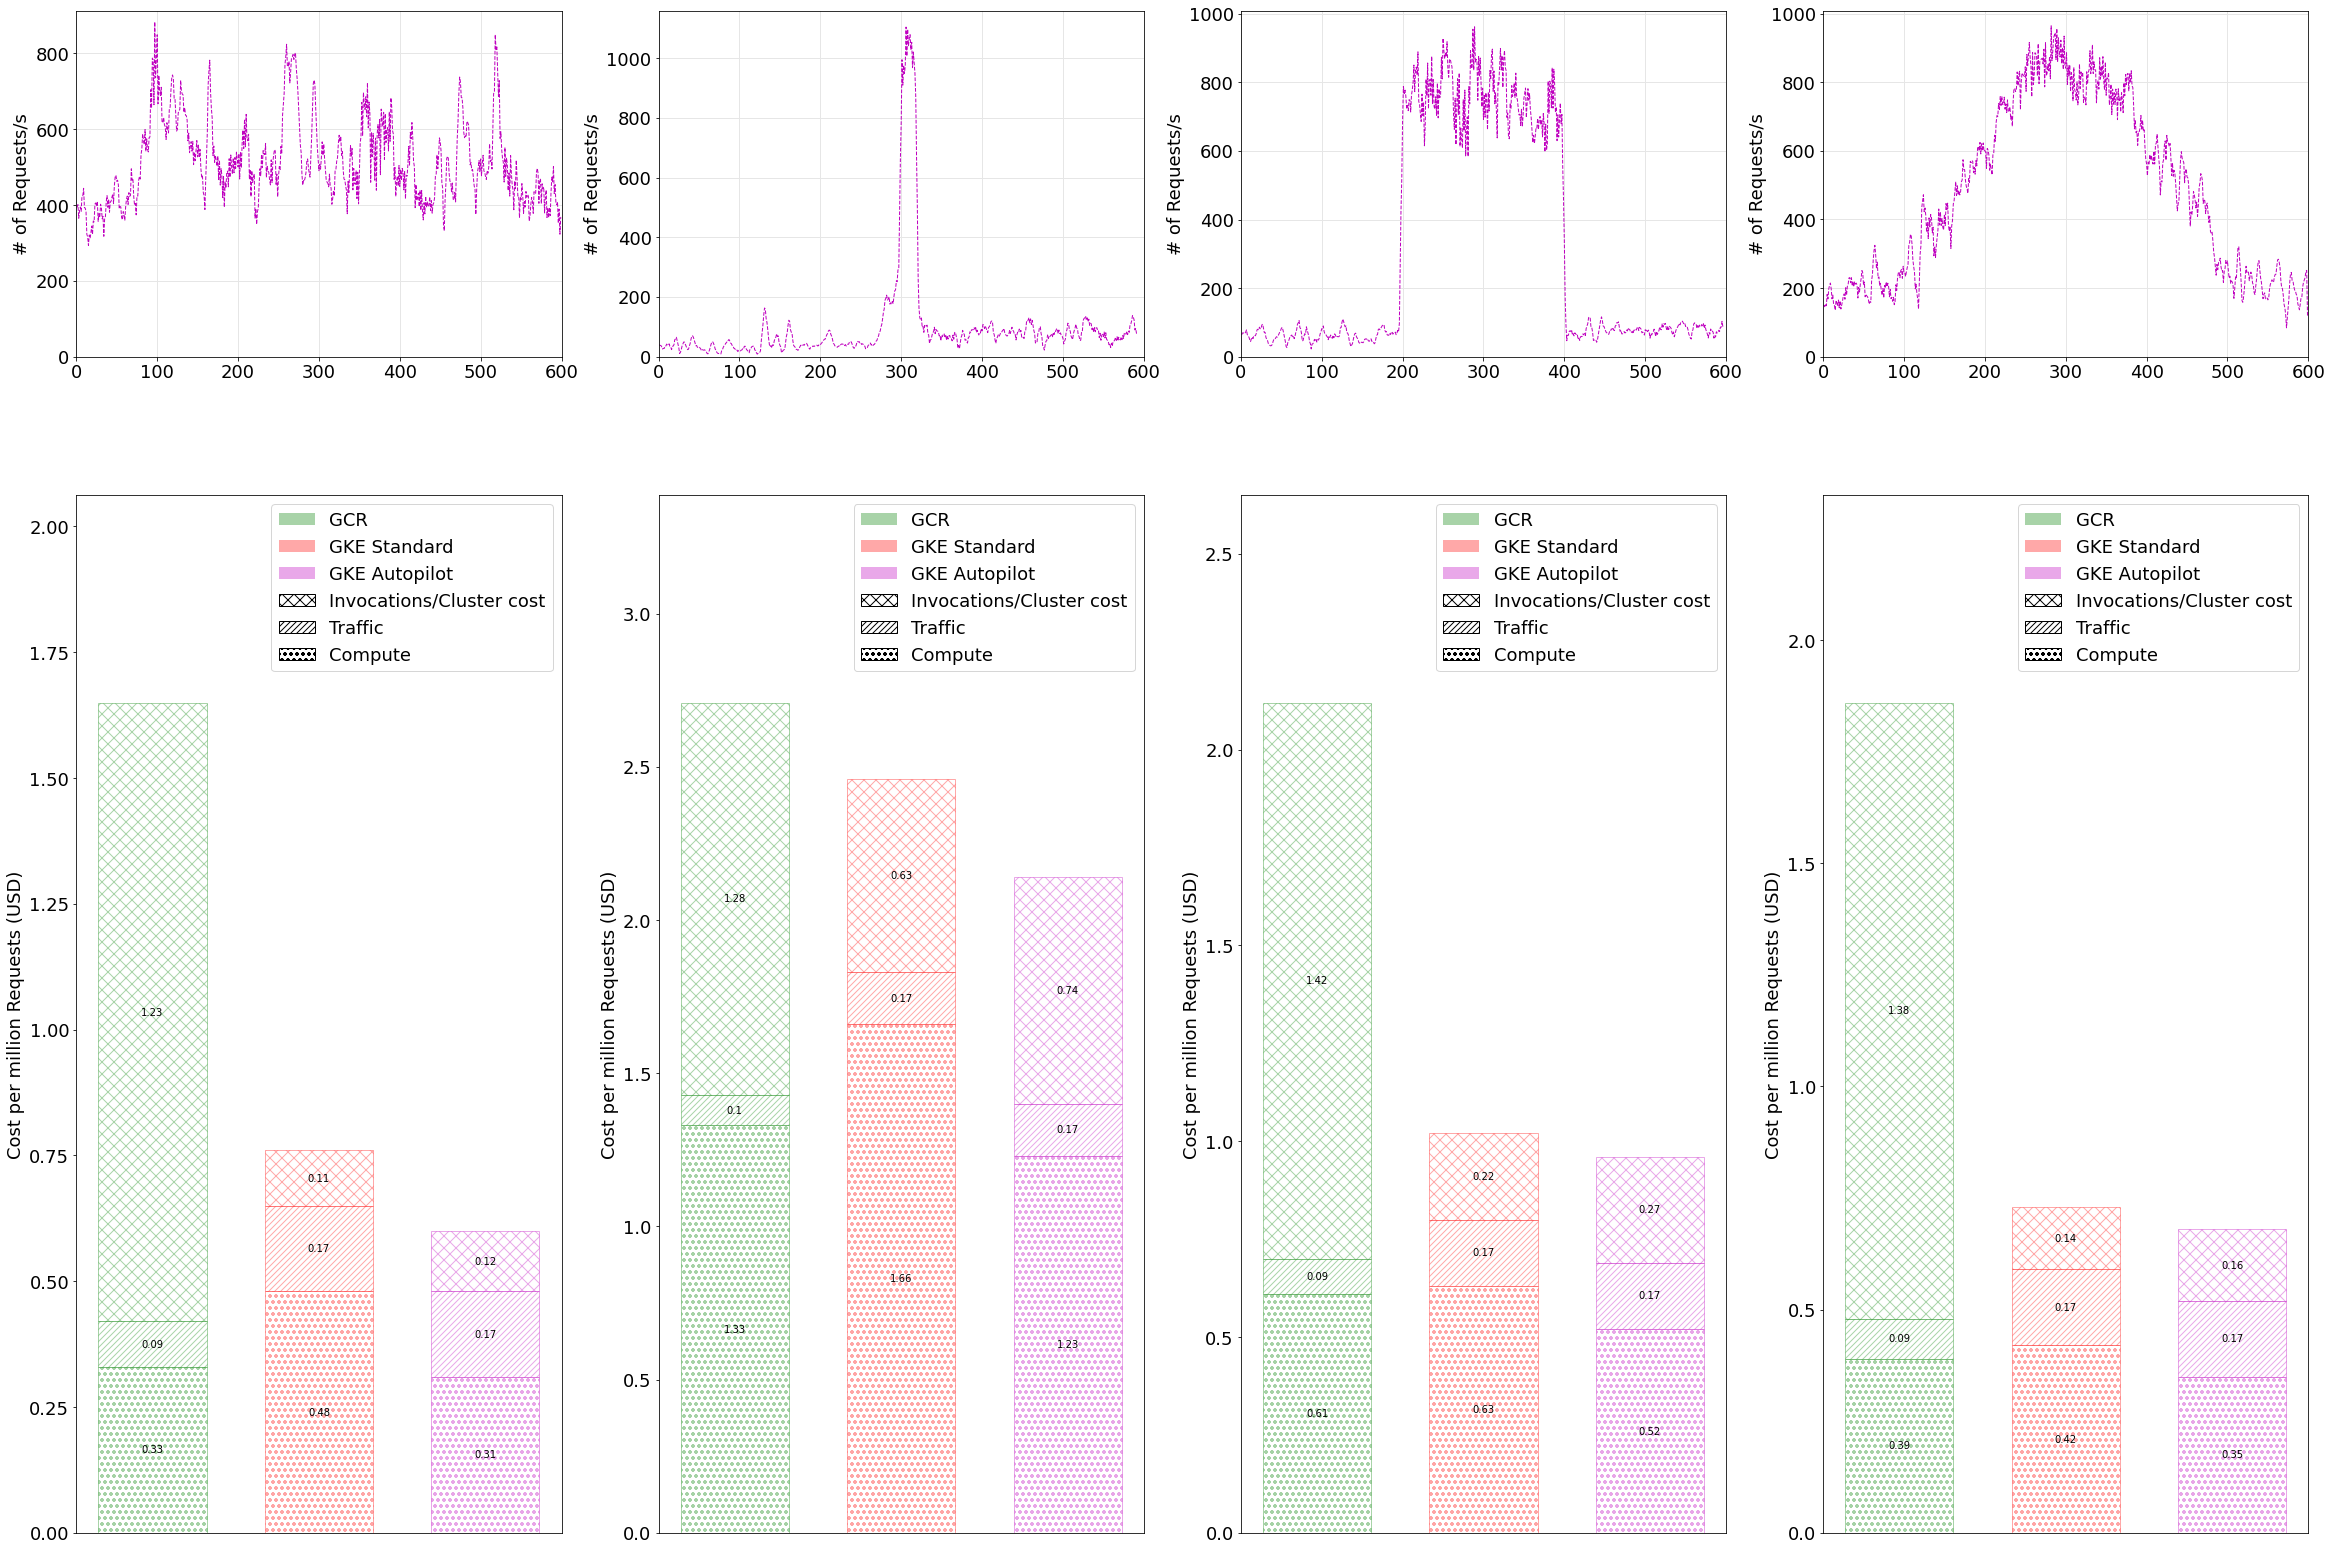

In [4]:
size_factor = 2

SMALL_SIZE = 14
MEDIUM_SIZE = 18
plt.rc('font', size=MEDIUM_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=MEDIUM_SIZE)
plt.rc('ytick', labelsize=MEDIUM_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('figure', titlesize=MEDIUM_SIZE)

fig, axs = plt.subplots(
    nrows=2,
    ncols=len(loads),
    figsize=(20 * size_factor, 14 * size_factor),
    gridspec_kw={"height_ratios": [1, 3]},
)

scenario = "browse"

for load_id, load in enumerate(loads):
    # Draw the top plot
    setup_id = 0
    infra = setups[setup_id][0]
    run_id = setups[setup_id][4]
    nr_req = data[scenario][load][infra][run_id]["nr_requests"]
    nr_req["mov_avg"] = nr_req["counts"].rolling(2).mean()

    axs[0][load_id].plot(nr_req["mov_avg"], "--m", label="avg", linewidth=1.0)
    axs[0][load_id].set_ylim(ymin=0)

    # Draw the lower plot
    labels = [setup[3] for setup in setups]
    hatches = ["oo", "////", "xx"]
    x = np.arange(len(setups))
    width = 0.65
    max_cost = 0

    for j, (infra, color, tick, label, run_id) in enumerate(setups):
        cost = get_cost(data[scenario][load][infra][run_id]["gcp_metrics"], data[scenario][load][infra][run_id]["k6_metrics"])
        max_cost = max(max_cost, cost.total())

        bar = axs[1][load_id].bar(
            x[j], [cost.c()], width, hatch=[hatches[0]], color="w", edgecolor=color, alpha=0.34
        )
        axs[1][load_id].bar_label(bar, label_type="center")

        bar = axs[1][load_id].bar(
            x[j],
            [cost.t()],
            width,
            hatch=[hatches[1]],
            color="w",
            edgecolor=color,
            bottom=cost.c(),
            alpha=0.34
        )
        axs[1][load_id].bar_label(bar, label_type="center")

        bar = axs[1][load_id].bar(
            x[j],
            [cost.m()],
            width,
            hatch=[hatches[2]],
            color="w",
            edgecolor=color,
            bottom=(cost.c() + cost.t()),
            alpha=0.34
        )
        axs[1][load_id].bar_label(bar, label_type="center")

        bar = axs[1][load_id].bar(
            x[j],
            [0],
            width,
            color=color,
            bottom=0,
            alpha=0.34,
            label=label
        )

    # Add labels, legends etc.
    axs[0][load_id].set(ylabel="# of Requests/s")
    axs[0][load_id].set_xlim(xmin=0, xmax=600)
    axs[0][load_id].grid(axis="both", color="0.9", linestyle="-", linewidth=1)

    axs[1][load_id].legend()
    axs[1][load_id].set(ylabel="Cost per million Requests (USD)")
    axs[1][load_id].set_xticks([], [])
    axs[1][load_id].set_ylim(ymax=max_cost * 1.25)

    legend_elements = [
        Patch(facecolor="w", hatch=hatches[2], edgecolor="k", label="Invocations/Cluster cost"),
        Patch(facecolor="w", hatch=hatches[1], edgecolor="k", label="Traffic"),
        Patch(facecolor="w", hatch=hatches[0], edgecolor="k", label="Compute"),
    ]
    handles, _ = axs[1][load_id].get_legend_handles_labels()
    handles.extend(legend_elements)
    axs[1][load_id].legend(handles=handles)

fig.savefig("cost_hr_browse.pdf", bbox_inches='tight')


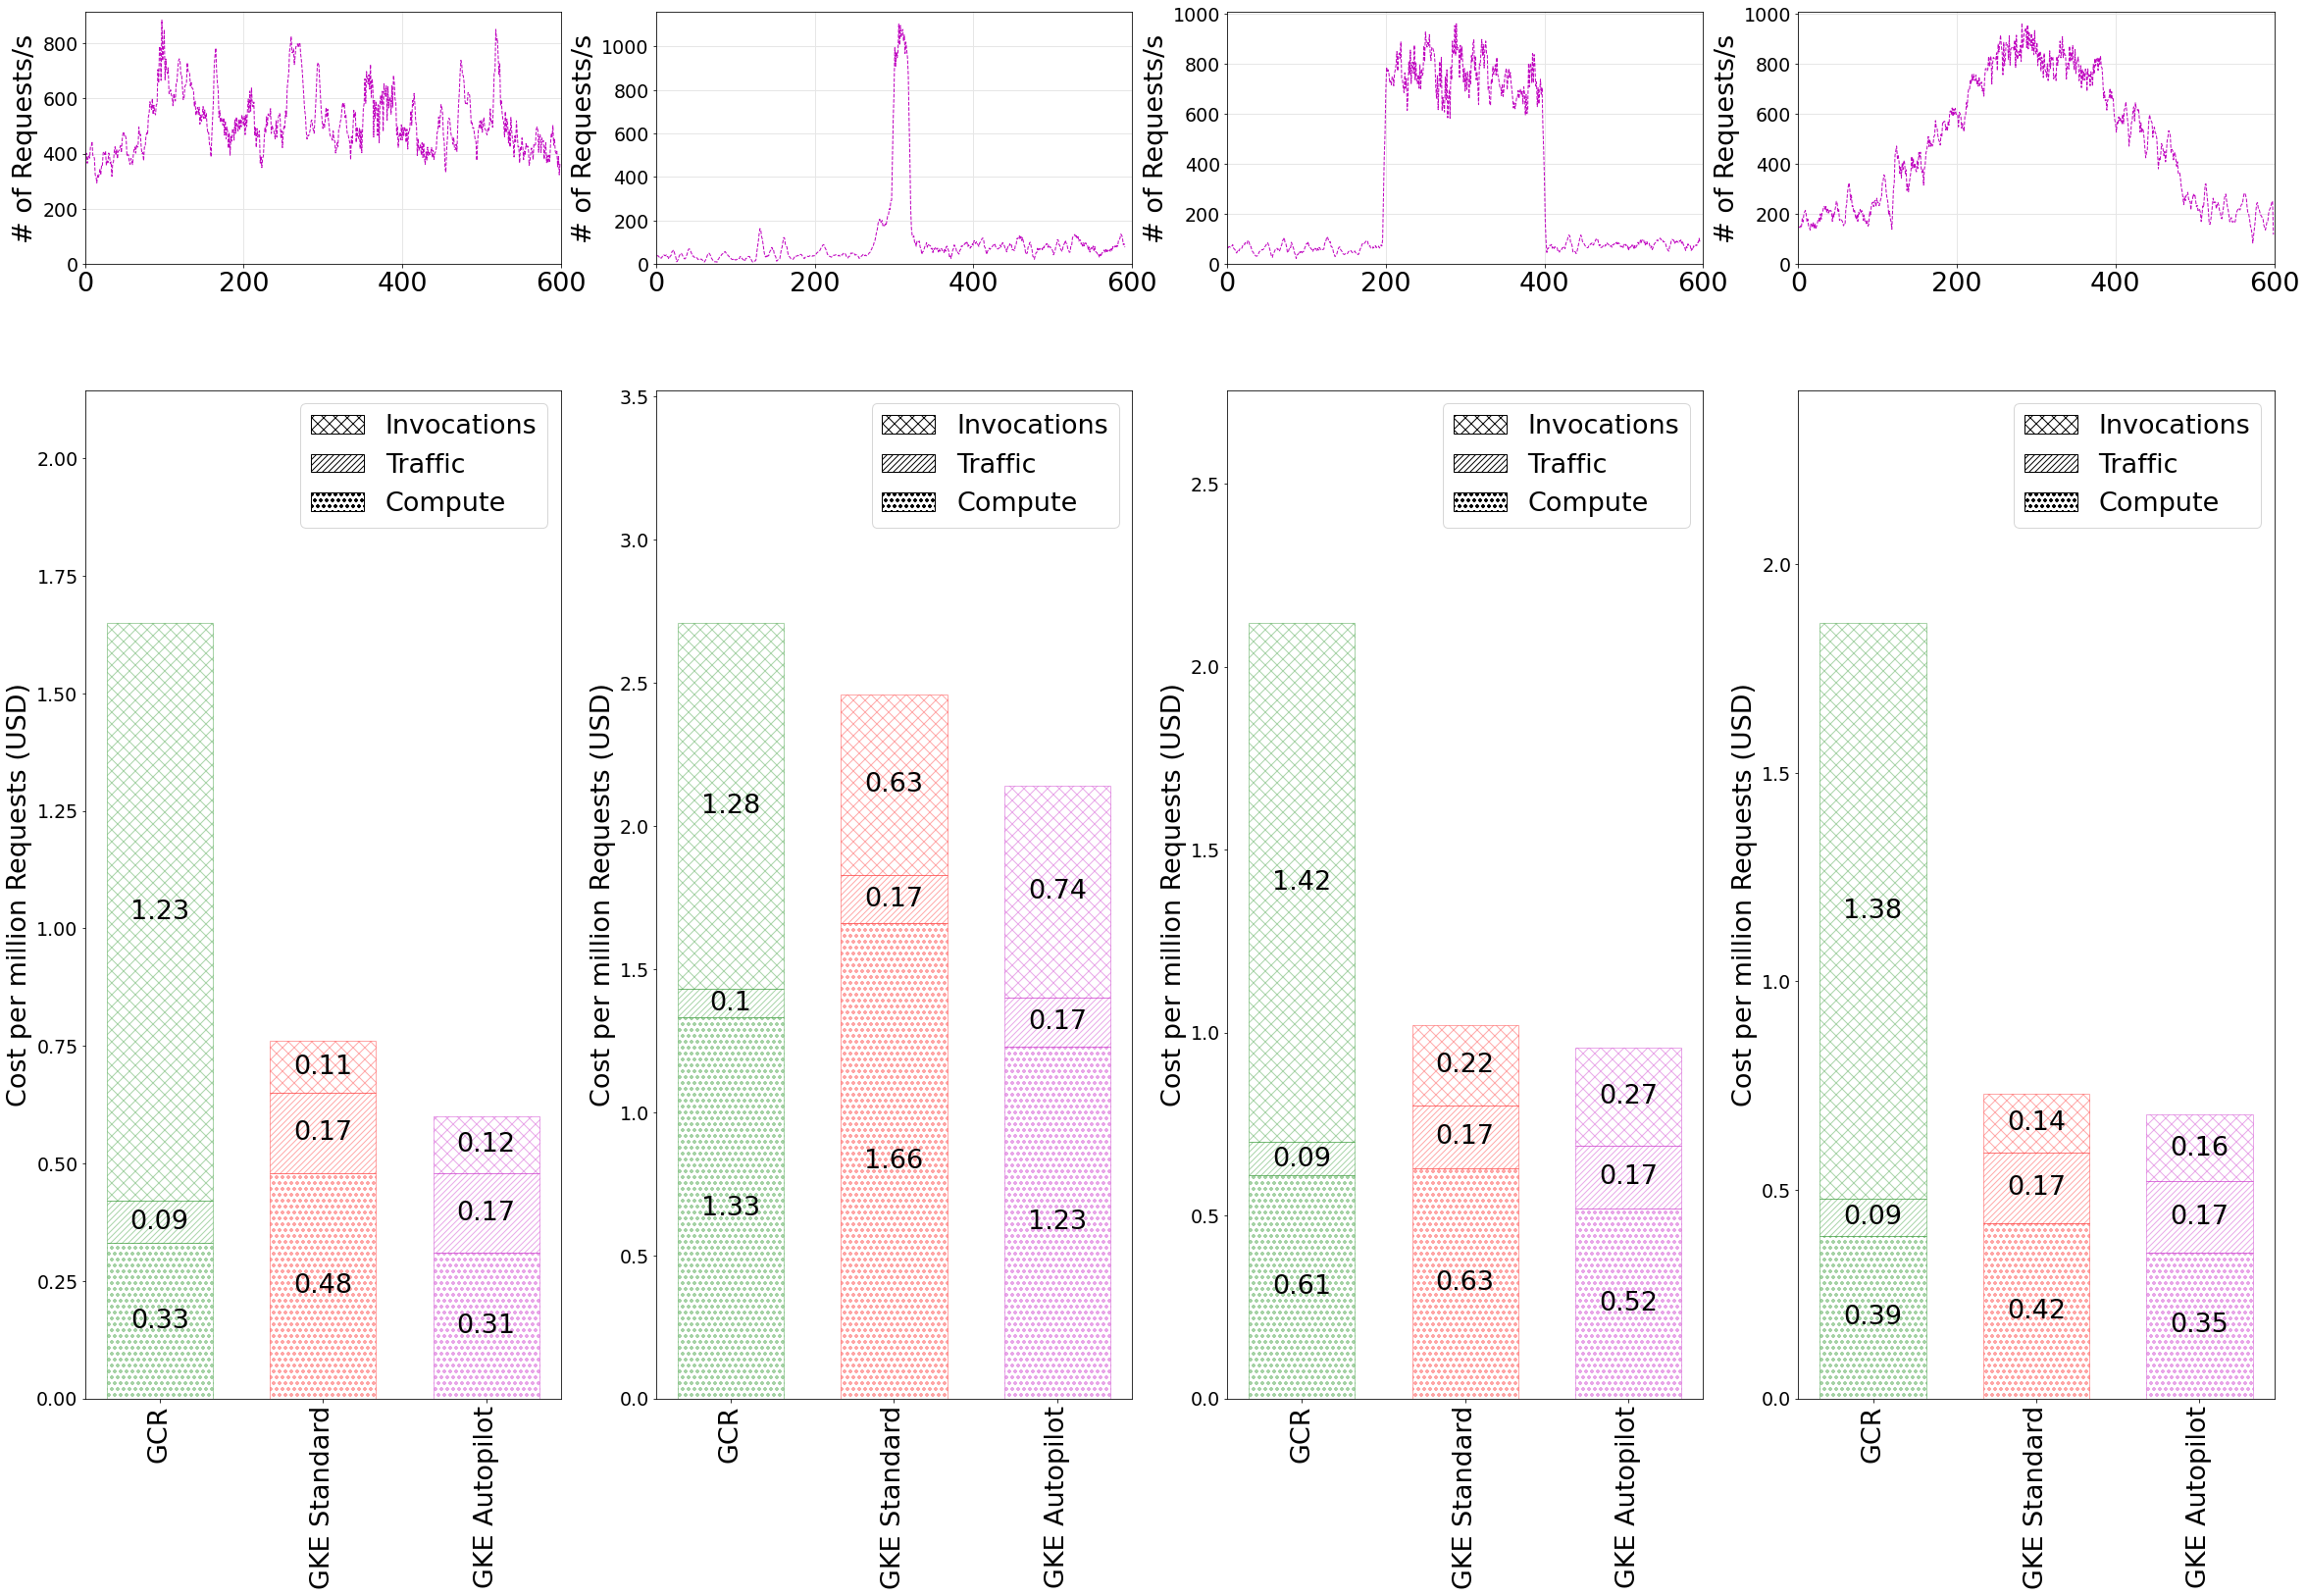

In [4]:

size_factor = 2

SMALL_SIZE = 23
MEDIUM_SIZE = 27
plt.rc('font', size=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=MEDIUM_SIZE)
plt.rc('ytick', labelsize=19)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('figure', titlesize=MEDIUM_SIZE)

fig, axs = plt.subplots(
    nrows=2,
    ncols=len(loads),
    figsize=(20 * size_factor, 13 * size_factor),
    gridspec_kw={"height_ratios": [1, 4]},
)

scenario = "browse"

for load_id, load in enumerate(loads):
    # Draw the top plot
    setup_id = 0
    infra = setups[setup_id][0]
    run_id = setups[setup_id][4]
    nr_req = data[scenario][load][infra][run_id]["nr_requests"]
    nr_req["mov_avg"] = nr_req["counts"].rolling(2).mean()

    axs[0][load_id].plot(nr_req["mov_avg"], "--m", label="avg", linewidth=1.0)
    axs[0][load_id].set_ylim(ymin=0)

    # Draw the lower plot
    labels = [setup[3] for setup in setups]
    hatches = ["oo", "////", "xx"]
    x = np.arange(len(setups))
    width = 0.65
    max_cost = 0

    for j, (infra, color, tick, label, run_id) in enumerate(setups):
        cost = get_cost(data[scenario][load][infra][run_id]["gcp_metrics"], data[scenario][load][infra][run_id]["k6_metrics"])
        max_cost = max(max_cost, cost.total())

        bar = axs[1][load_id].bar(
            x[j], [cost.c()], width, hatch=[hatches[0]], color="w", edgecolor=color, alpha=0.34
        )
        axs[1][load_id].bar_label(bar, label_type="center")

        bar = axs[1][load_id].bar(
            x[j],
            [cost.t()],
            width,
            hatch=[hatches[1]],
            color="w",
            edgecolor=color,
            bottom=cost.c(),
            alpha=0.34
        )
        axs[1][load_id].bar_label(bar, label_type="center")

        bar = axs[1][load_id].bar(
            x[j],
            [cost.m()],
            width,
            hatch=[hatches[2]],
            color="w",
            edgecolor=color,
            bottom=(cost.c() + cost.t()),
            alpha=0.34
        )
        axs[1][load_id].bar_label(bar, label_type="center")

        # bar = axs[1][load_id].bar(
        #     x[j],
        #     [0],
        #     width,
        #     color=color,
        #     bottom=0,
        #     alpha=0.34,
        #     label=label
        # )

    # Add labels, legends etc.
    axs[0][load_id].set(ylabel="# of Requests/s")
    axs[0][load_id].set_xlim(xmin=0, xmax=600)
    axs[0][load_id].grid(axis="both", color="0.9", linestyle="-", linewidth=1)

    # axs[1][load_id].legend()
    axs[1][load_id].set(ylabel="Cost per million Requests (USD)")
    axs[1][load_id].set_xticks(x, [y[3] for y in setups], rotation=90,)
    # ax.set_xticks([1, 2, 3], labels, rotation=45, ha='right')
    axs[1][load_id].set_ylim(ymax=max_cost * 1.3)

    axs[1][load_id].set_xticks(x, labels)


    legend_elements = [
        Patch(facecolor="w", hatch=hatches[2], edgecolor="k", label="Invocations"),
        Patch(facecolor="w", hatch=hatches[1], edgecolor="k", label="Traffic"),
        Patch(facecolor="w", hatch=hatches[0], edgecolor="k", label="Compute"),
    ]
    handles, _ = axs[1][load_id].get_legend_handles_labels()
    handles.extend(legend_elements)
    axs[1][load_id].legend(handles=handles)

fig.savefig("cost_hr_browse.pdf", bbox_inches='tight')
